In [8]:
import numpy as np
import scipy
from scipy.io import wavfile
from scipy import signal
import tensorflow as tf
from tensorflow import keras

Code from https://www.tensorflow.org/tutorials/audio/simple_audio

In [22]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [11]:
# languages = ['en', 'it']
# path = '../Data'
path = '/scratch/na5zn/Audio-Language-Detection/Data/segments'

In [14]:
data_dir = pathlib.Path(path)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Languages:', commands)

Languages: ['en' 'it']


In [15]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 29734
Number of examples per label: 14881
Example file tensor: tf.Tensor(b'/scratch/na5zn/Audio-Language-Detection/Data/segments/en/divinecomedy_longfellow_03_dante_64kb_340.wav', shape=(), dtype=string)


In [100]:
train_size = int(0.7*num_samples)
val_size = int(0.15*num_samples)
test_size = num_samples - train_size - val_size

train_files = filenames[:train_size]
val_files = filenames[train_size: train_size + val_size]
test_files = filenames[-val_size:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 23787
Validation set size 2973
Test set size 2973


In [101]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [102]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

In [103]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [104]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


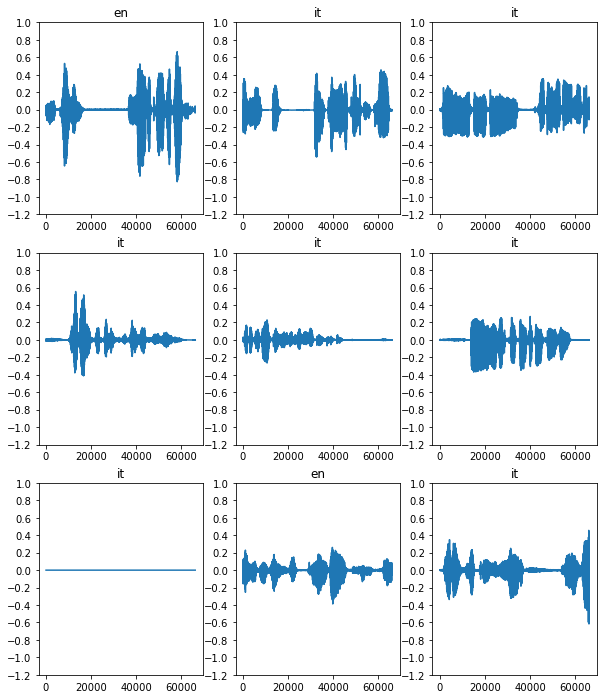

In [105]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [106]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    print(tf.shape(waveform))
    zero_padding = tf.zeros([66150] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [107]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=22050))

tf.Tensor([66150], shape=(1,), dtype=int32)
Label: en
Waveform shape: (66150,)
Spectrogram shape: (515, 129)
Audio playback


/home/na5zn/.conda/envs/tf_keras_tqdm/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


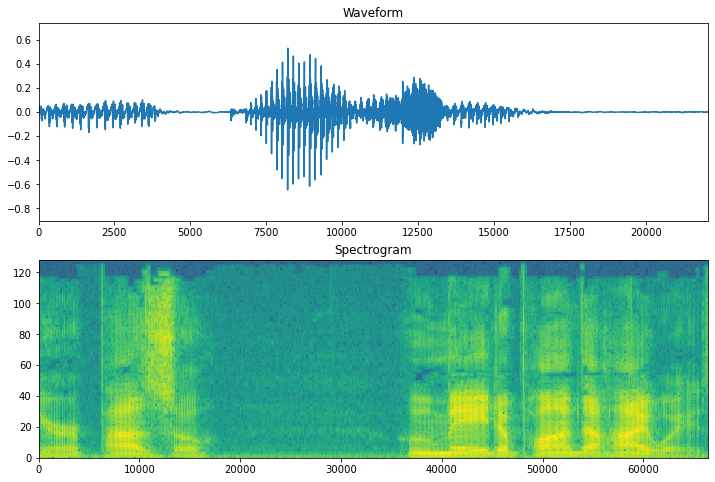

In [108]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 22050])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [109]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [110]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Tensor("Shape:0", shape=(1,), dtype=int32)


/home/na5zn/.conda/envs/tf_keras_tqdm/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


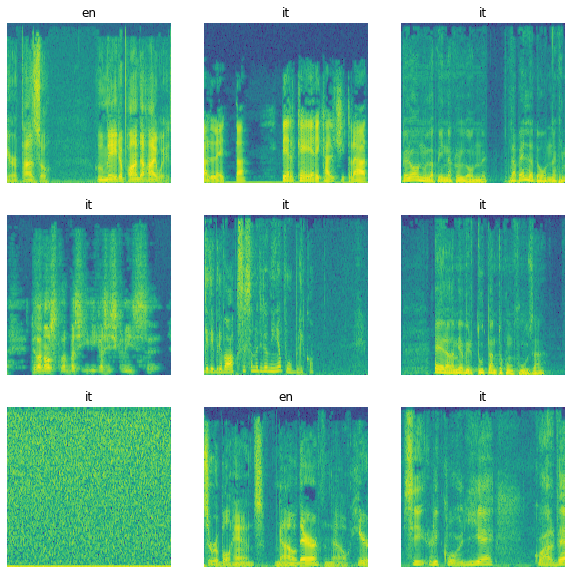

In [111]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

In [112]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [113]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Tensor("Shape:0", shape=(1,), dtype=int32)
Tensor("Shape:0", shape=(1,), dtype=int32)


In [114]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [115]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [116]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

keras.backend.clear_session()

inputs = keras.Input(shape=input_shape)
x = keras.layers.Conv2D(32, 16, padding='same')(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2,2), padding='same')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_labels, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=x)

# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     preprocessing.Resizing(32, 32), 
#     norm_layer,
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_labels),
# ])

model.summary()

Input shape: (515, 129, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 515, 129, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 515, 129, 32)      8224      
_________________________________________________________________
re_lu (ReLU)                 (None, 515, 129, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 258, 65, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 536640)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1073282   
Total params: 1,081,506
Trainable params: 1,081,506
Non-trainable params: 0
________________________

In [117]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 20
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/20
372/372 [==============================] - 2553s 7s/step - loss: 0.6818 - accuracy: 0.6729 - val_loss: 0.2892 - val_accuracy: 0.8887
Epoch 2/20
372/372 [==============================] - 2140s 6s/step - loss: 0.2519 - accuracy: 0.8984 - val_loss: 0.2088 - val_accuracy: 0.9169
Epoch 3/20
372/372 [==============================] - 2137s 6s/step - loss: 0.1552 - accuracy: 0.9400 - val_loss: 0.2137 - val_accuracy: 0.9199
Epoch 4/20
372/372 [==============================] - 2134s 6s/step - loss: 0.1125 - accuracy: 0.9596 - val_loss: 0.1803 - val_accuracy: 0.9425
Epoch 5/20
372/372 [==============================] - 2140s 6s/step - loss: 0.0837 - accuracy: 0.9714 - val_loss: 0.2231 - val_accuracy: 0.9364
Epoch 6/20
372/372 [==============================] - 2143s 6s/step - loss: 0.0920 - accuracy: 0.9650 - val_loss: 0.2372 - val_accuracy: 0.9354
Epoch 7/20
372/372 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9762

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()